In [1]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 132.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
# From simple audio example
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [4]:
import sys

import numpy as np
from keras import Model
from keras import Layer
# Load model from
def import_model(filepath: str) -> Model:
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [6]:
# Split model into layers with inputs, weights and biases
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [7]:
#Load audio dataset from Google
DATASET_PATH = 'data/mini_speech_commands_extracted'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [8]:
# Function for FFT and Spectrogram
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



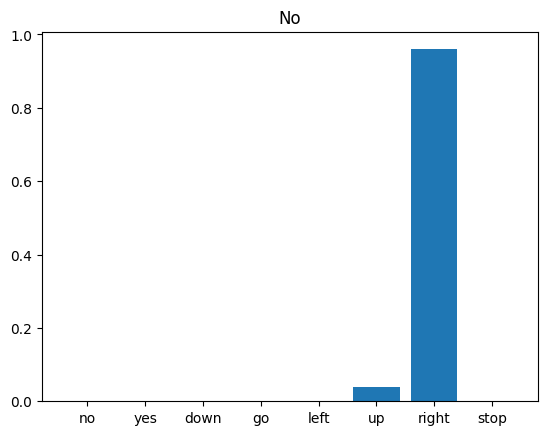

In [10]:
x = data_dir/'mini_speech_commands/up/016e2c6d_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [5]:
# Tähän tehdään neuroverkon viimeinen laskenta toka dense_1 layerille
def data_get(inputs, weights, bias):
   inputs = np.array(inputs)
   weights = np.array(weights)
   bias = np.array(bias)

   print("Input shape:", inputs.shape)
   print("Weights shape:", weights.shape, "Wights have: ", weights)
   print("Bias shape:", bias.shape, "bias", bias)

def data_get_noArgs(inputs):
   inputs = np.array(inputs)

   print("Input shape:", inputs.shape[0], ",", inputs.shape[1], ",", inputs.shape[2], ",", inputs.shape[3])
   return 0

#----------------------------------------------------------------------------------#

def ReLU(x):
    if(x >= 0):
     return x
    else:
     return 0

#----------------------------------------------------------------------------------#

def conv2dLayer1(inputs, weights, bias):
    inputs = np.array(inputs)
    weights = np.array(weights)
    bias = np.array(bias)

    batch, height, width, channels = inputs.shape
    outputChannels = bias.shape[0]
    filterHeight = weights.shape[0]
    filterWidth = weights.shape[1]
    resHeight = height - filterHeight + 1
    resWidth = width - filterWidth + 1
    result = np.zeros((batch, resHeight, resWidth, outputChannels))

    for b in range(batch):
       for ch in range(outputChannels):
          for rH in range(resHeight):
             for rW in range(resWidth):
                filterSum = 0
                for fH in range(filterHeight):
                   for fW in range(filterWidth):
                      for fCH in range(channels):
                         filterSum += inputs[b, rH + fH, rW + fW, fCH] * weights[fH, fW, fCH, ch]
                         result[b, rH, rW, ch] = filterSum + bias[ch]
                         result[b, rH, rW, ch] = ReLU(result[b, rH, rW, ch])



    return result


def conv2dLayer(inputs, weights, bias):
    inputs = np.array(inputs)
    weights = np.array(weights)
    bias = np.array(bias)

    batch, height, width, filterChannels = inputs.shape
    filterHeight = weights.shape[0]
    filterWidth = weights.shape[1]
    resultHeight = height - filterHeight + 1
    resultWidth  = width - filterWidth + 1
    channels = bias.shape[0]
    result = np.zeros((batch, resultHeight, resultWidth, channels))

    for b in range(batch):
       for rH in range(resultHeight):
          for rW in range(resultWidth):
             for ch in range(channels):
                filterSum = 0
                for fH in range(filterHeight):
                   for fW in range(filterWidth):
                      for inCH in range(filterChannels):
                         filterSum = filterSum + inputs[b, rH + fH, rW + fW, inCH] * weights[fH, fW, inCH, ch]
                result[b, rH, rW, ch] = filterSum + bias[ch]
                result[b, rH, rW, ch] = ReLU(result[b, rH, rW, ch])

    return result

#----------------------------------------------------------------------------------#

def maxPooling2D(inputs):
   inputs = np.array(inputs)
   amount, height, width,channels = inputs.shape

   result = np.zeros((amount, height // 2, width // 2, channels))

   for a in range(amount):
      for c in range(channels):
         for h in range(height // 2):
            for w in range(width // 2):
               block2d = np.zeros((2,2))
               for hb in range(2):
                  for wb in range(2):
                     block2d[hb,wb] = inputs[a, h * 2 + hb, w * 2 + wb, c]
               result[a, h, w, c] = np.max(block2d)
   return result
#----------------------------------------------------------------------------------#

def flatten(inputs):
    inputs = np.array(inputs)
    outputSize = inputs.shape[1] * inputs.shape[2] * inputs.shape[3]
    print(outputSize)
    result = np.zeros((inputs.shape[0],outputSize))

    result = inputs.reshape((inputs.shape[0], outputSize))
    return result

def dense(inputs, weights, bias):
    inputs  = np.array(inputs)
    weights = np.array(weights)
    bias = np.array(bias)

    outputSize = bias.shape[0] #Should be 128
    inputSize =  inputs.shape[1] #Should be 12544
    outputAmount = inputs.shape[0] #Should be 1 (2 arrays)

    result = np.zeros((outputAmount, outputSize))

    for i in range(outputAmount):
     for x in range(outputSize):
      for y in range(inputSize):
       result[i,x] += inputs[i,y] * weights[y,x]
      result[i,x] += bias[x]
      result[i,x] = ReLU(result[i,x])

    return result

#----------------------------------------------------------------------------------#
def dense_layer2(inputs, weights, bias):
   #Ensure that whatever we are getting is translated to numpy
   inputs = np.array(inputs)
   weights = np.array(weights)
   bias = np.array(bias)

   inputs_range_dimensions = inputs.shape[0] #check how many dimensions result has
   inputs_range = inputs.shape[1] #128 values
   output_range = bias.shape[0] #8 values
   #get the shape of each input for the for loop
   result = np.zeros((inputs_range_dimensions,output_range))

   for i in range(inputs_range_dimensions):
    for n in range(output_range):
     for w in range(inputs_range):
       #Inputs- 1,128, weights 128,8, bias(8)
       result[i,n] = result[i,n] + inputs[i,w] * weights[w,n]
     result[i,n] = result[i,n] + bias[n]
   return result


<Sequential name=sequential_4, built=True>
<Dense name=dense_1, built=True>
<Sequential name=sequential_5, built=True>
[(128, 8), (8,)]
(1, 128)
12544
Layer shape =  (1, 8)
Layer comparison:  2.0494203822191137e-07
Original layer shape:  (1, 8) My layer shape:  (1, 8)
tf.Tensor(
[-5.885276    0.9491778  -0.4829279  -0.80634487 -5.8623486   4.50151
  7.7014246  -8.871557  ], shape=(8,), dtype=float32)


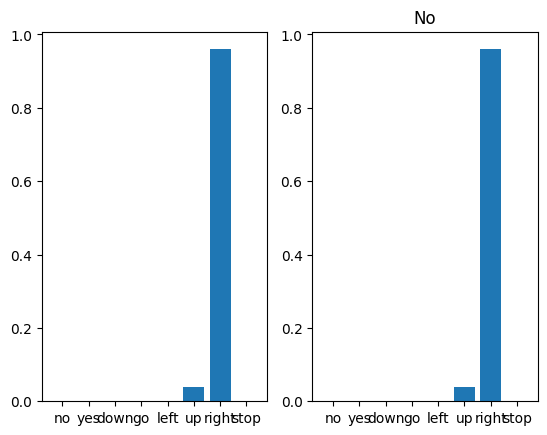

In [13]:
'''
Homma kannattaisi aloittaa verkon loppupäästä

'''


Layer = "dense_1"
(start, layer, end) = get_reference_layer(Layer, model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights(Layer,model)))
weights = get_layer_weights(Layer,model)

#print("Original input", model.input_shape)
#print("Start input", start.input_shape)
#print("Layer input", layer.input.shape)
#print("End input", end.input_shape)

# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
a0 = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
print(a0.shape)
#w1 = weights[0]
#print("w1 = ", w1)
#print("w1 shape = ", w1.shape)
#b1 = weights[1]
#print("b1 = ", b1)
#print("b1 shape = ", b1.shape)
#layer_oma_result = dense(a0,w1,b1)
#layer_oma_result = resize_layer(a0)

test_mode = 1
if(test_mode == 1):
  (start1, layer1, end1) = get_reference_layer("conv2d", model)
  result1 = start1(x)
  a1 = result1
  #----conv2D1Res---------#
  wc2D, bc2D = get_layer_weights("conv2d", model)
  conv2D1Res = conv2dLayer1(a1, wc2D, bc2D)
  #----conv2D2Res---------#
  wc2D2, bc2D2 = get_layer_weights("conv2d_1", model)
  conv2D2Res = conv2dLayer(conv2D1Res, wc2D2, bc2D2)
  #----maxPooling2DRes----#
  maxPooling2DRes = maxPooling2D(conv2D2Res)
  #-------flattenRes------#
  flattenRes = flatten(maxPooling2DRes)
  #----firstDesneRes------#
  wd1, bd1 = get_layer_weights("dense",model)
  fristDenseRes = dense(flattenRes, wd1, bd1)
  #---secondDenseRes------#
  wd2, bd2 = get_layer_weights("dense_1", model)
  secondDenseRes = dense_layer2(fristDenseRes, wd2, bd2)
  #---FinalResult---------#
  layer_oma_result = secondDenseRes

#print("Oma tulos = ",layer_oma_result)
#print("Tuloksen shape =", layer_oma_result.shape)

layerSample = np.array(layer_result)


#print("Oma tulos: ", layer_oma_result)
#print("Layerin tulos = ", layer_result)
print("Layer shape = ", layer_result.shape)

difference = layerSample - layer_oma_result
absolute = np.abs(difference)
average = np.mean(absolute)
print("Layer comparison: ", average)
print("Original layer shape: ", layerSample.shape, "My layer shape: ", layer_oma_result.shape)
print(layer_result[0,:])
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result[0,:]))
plt.title('No')
plt.show()